In [ ]:
# set project root and dir
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add the project root to the system path
if project_root not in sys.path:
    sys.path.append(project_root)

In [ ]:
# import libraries and helpers
import pandas as pd
from helpers.processing_helpers import define_dataset, clean_texts_spacy
from helpers.visualization_helpers import plot_class_distribution
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE
import joblib
import spacy
import numpy as np

In [ ]:
# Load spaCy model
nlp = spacy.load('en_core_web_lg')

# define path located in dir
file_path = '../tripadvisor_hotel_reviews.csv'

# make sure the file is there and the path is correct 
if os.path.exists(file_path):
    full_df, reviews_df, ratings_df = define_dataset(file_path)
    print("Dataset Loaded Successfully!")
    print("\nDataset Overview:")
    display(full_df.head())
else:
    raise FileNotFoundError(f"Dataset not found at path: {file_path}")

Dataset Loaded Successfully!

Dataset Overview:


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
# Clean the review texts using spaCy
reviews_df['cleaned_review'] = clean_texts_spacy(reviews_df['Review'])

# Display sample cleaned reviews
print("\nSample of Cleaned Reviews:")
display(reviews_df[['Review', 'cleaned_review']].head())


Sample of Cleaned Reviews:


,Review,cleaned_review
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking get good deal sta...
1,ok nothing special charge diamond member hilto...,ok special charge diamond member hilton decide...
2,nice rooms not 4* experience hotel monaco seat...,nice room 4 experience hotel monaco seattle go...
3,"unique, great stay, wonderful time hotel monac...",unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",great stay great stay go seahawk game awesome ...


c:\Users\paige\OneDrive\Desktop\6148 - NLP\Project 2\nlp_proj2_hotelreviews\Run 2\helpers\visualization_helpers.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


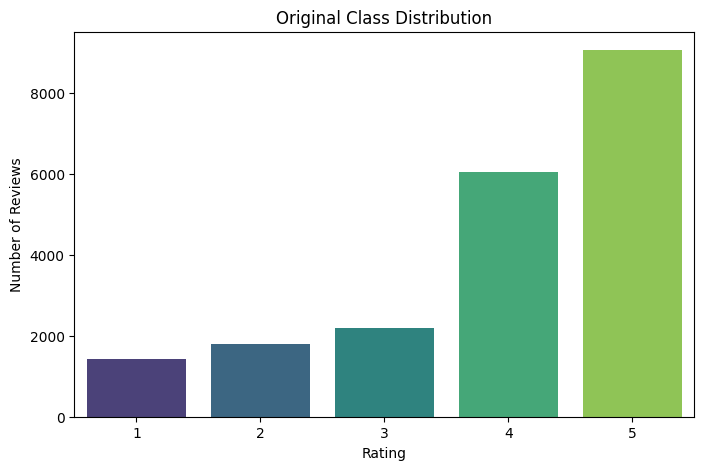

In [ ]:
# EDA

# plot original class distribition
plot_class_distribution(
    ratings_df['Rating'], 
    title="Original Class Distribution", 
    save_path='../outputs/figures/original_class_distribution.png'
)

In [ ]:
# split testing and training data 
X = reviews_df['cleaned_review']
y = ratings_df['Rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21, stratify=y
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")



Training set size: 16392
Testing set size: 4099


In [ ]:
# different vectorization methods 

# Initialize fit and tranform TFIDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# initialize fit and transform bag of words
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# spacy word embeddings
def spacy_vectorizer(texts, nlp_model):
    vectors = []
    for doc in nlp_model.pipe(texts, disable=["parser", "ner"]):
        vectors.append(doc.vector)
    return np.array(vectors)

# get spacy features
X_train_spacy = spacy_vectorizer(X_train, nlp)
X_test_spacy = spacy_vectorizer(X_test, nlp)

In [ ]:
# save vectorizers
joblib.dump(tfidf_vectorizer, '../outputs/models/tfidf_vectorizer.joblib')
joblib.dump(bow_vectorizer, '../outputs/models/bow_vectorizer.joblib')
joblib.dump(nlp, '../outputs/models/spacy_model.joblib')

print("\nVectorization complete and vectorizers saved.")


Vectorization complete and vectorizers saved.


c:\Users\paige\OneDrive\Desktop\6148 - NLP\Project 2\nlp_proj2_hotelreviews\Run 2\helpers\visualization_helpers.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


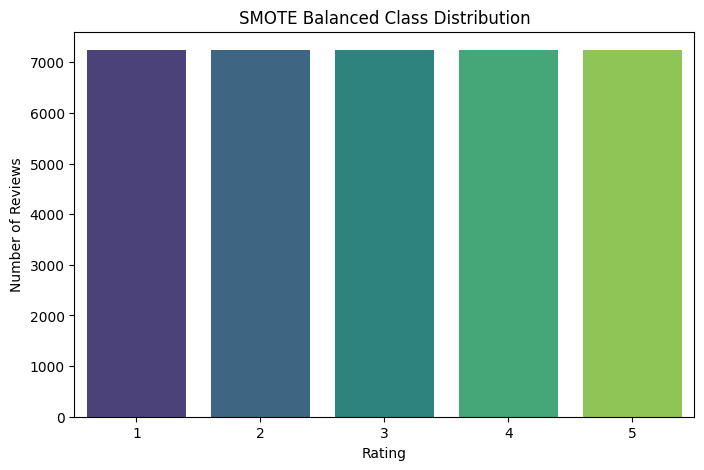


Class distribution after SMOTE:
TF-IDF Balanced: Rating
1    7243
2    7243
3    7243
4    7243
5    7243
Name: count, dtype: int64
BoW Balanced: Rating
1    7243
2    7243
3    7243
4    7243
5    7243
Name: count, dtype: int64
spaCy Balanced: Rating
1    7243
2    7243
3    7243
4    7243
5    7243
Name: count, dtype: int64


In [ ]:
# Initialize SMOTE to balence classes
smote = SMOTE(random_state=21)

# SMOTE for each word embedding technique
X_train_tfidf_balanced, y_train_tfidf_balanced = smote.fit_resample(X_train_tfidf, y_train)
X_train_bow_balanced, y_train_bow_balanced = smote.fit_resample(X_train_bow, y_train)
X_train_spacy_balanced, y_train_spacy_balanced = smote.fit_resample(X_train_spacy, y_train)

# plot  new class distribution
plot_class_distribution(
    y_train_tfidf_balanced, #these are all the same # (as shown below) so just plot one 
    title="SMOTE Balanced Class Distribution", 
    save_path='../outputs/figures/original_class_distribution.png'
)

print("\nClass distribution after SMOTE:")
print("TF-IDF Balanced:", pd.Series(y_train_tfidf_balanced).value_counts(sort=False).sort_index())
print("BoW Balanced:", pd.Series(y_train_bow_balanced).value_counts(sort=False).sort_index())
print("spaCy Balanced:", pd.Series(y_train_spacy_balanced).value_counts(sort=False).sort_index())

In [ ]:
# save everything to outputs -> models
joblib.dump(X_train_tfidf_balanced, '../outputs/models/X_train_tfidf_balanced.joblib')
joblib.dump(y_train_tfidf_balanced, '../outputs/models/y_train_tfidf_balanced.joblib')

joblib.dump(X_train_bow_balanced, '../outputs/models/X_train_bow_balanced.joblib')
joblib.dump(y_train_bow_balanced, '../outputs/models/y_train_bow_balanced.joblib')

joblib.dump(X_train_spacy_balanced, '../outputs/models/X_train_spacy_balanced.joblib')
joblib.dump(y_train_spacy_balanced, '../outputs/models/y_train_spacy_balanced.joblib')

joblib.dump(X_test_tfidf, '../outputs/models/X_test_tfidf.joblib')
joblib.dump(y_test, '../outputs/models/y_test.joblib')

print("\nPreprocessed data saved successfully!")



Preprocessed data saved successfully!
